# YAP 471 Computational Finance Project - Spring 2023-2024
Author: Ömer Faruk Merey

Student Number: 201101054

Topic: Optimal Portfolio based on Future Price Prediction.

Note: This note will be compared with Kerem Ihsan Ulasans work to report the comparison on portfolio creation.

Github Repo: https://github.com/OmerFarukMerey/Risk-Analysis-and-Portfolio-Creation-with-Genetic-Algorithms-using-statiscal-analysis

### Table of Contents
* [Tool Requirements](#tool)
* [CNN-LSTM](#cnn_lstm)
    * [Data Preparation](#data_prep_cnn_lstm)
    * [Model](#model_cnn_lstm)
    * [Evaluation](#eval_cnn_lstm)
* [RNN](#rnn)
    * [Data Preparation](#data_prep_rnn)
    * [Model](#model_rnn)
    * [Evaluation](#eval_rnn)
* [XGBoost](#xgboost)
    * [Data Preparation](#data_prep_xgboost)
    * [Model](#model_xgboost)
    * [Evaluation](#eval_xgboost)
* [Save Datasets](#save_datasets)

In [493]:
# Put on the name of the Stock
STOCK_NAME = "UNH"
DF_POSTFIX = "_Predictions.csv"

# Tool Requirements<a class="anchor" id="tool"></a>
Contains imports and helper functions for the upcoming sections

In [226]:
# Download neccessary libs
!pip install ta
!pip install yfinance
!pip install tensorflow
!pip install xgboost

In [494]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn import preprocessing
from ta.volatility import BollingerBands
from ta.trend import MACD
from ta.momentum import RSIIndicator
from keras.models import Sequential
from keras.layers import Conv1D,MaxPool1D,Bidirectional,LSTM,Dropout,TimeDistributed
from keras.layers import Dense,GlobalAveragePooling2D
from ta.trend import IchimokuIndicator
from sklearn.linear_model import LinearRegression
from keras.layers import Conv1D,Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed,MaxPool2D
from keras.layers import Dense,GlobalAveragePooling2D
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [495]:
def download_stock(stock_name):
    """
    Downloads the stock dataframe and returns it.
    """
    print(f"Downloading the data for {stock_name}")
    df = yf.download(
        [stock_name],
        group_by="ticker",
        start="2010-01-01",
        end="2024-01-01",
        progress=False,
    )
    print(f"Download complete for {stock_name}")
    df.round(4)
    df = df.reset_index()
    return df

def create_corr_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
    plt.title('Stock Correlation Matrix Heatmap')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()
    
def create_moving_average(df, moving_average_days=[20, 50, 100, 200]):
    for moving_average in moving_average_days:
        for company in df:
            column_name = f'MA{moving_average}'
            df[column_name] = df["Close"].rolling(moving_average).mean()
    return df.iloc[max(moving_average_days):]

def create_bollinger_bands(df):
    indicator_bb = BollingerBands(close=df["Close"])
    df['bb_bbm'] = indicator_bb.bollinger_mavg()
    df['bb_bbh'] = indicator_bb.bollinger_hband()
    df['bb_bbl'] = indicator_bb.bollinger_lband()
    return df

def create_macd(df):
    macd = MACD(close=df["Close"])
    df['macd'] = macd.macd()
    return df

def create_rsi(df):
    rsi = RSIIndicator(close=df["Close"])
    df['rsi'] = rsi.rsi()
    return df

def create_ichi(df):
    ichi = IchimokuIndicator(high=df["High"],low=df["Low"])
    df['ichi_a'] = ichi.ichimoku_a()
    df['ichi_b'] = ichi.ichimoku_b()
    df['ichi_base'] = ichi.ichimoku_base_line()
    df['ichi_conv'] = ichi.ichimoku_conversion_line()
    return df

def get_2020_first_index(df):
    x = df[df["Date"] > '2020-01-01'].index[0]
    return x

def get_first_index(df):
    x = df.index[0]
    return x

def create_pred_real_df(test_label, predicted):
    volatility = calculate_volatility(predicted)
    
    df = pd.DataFrame({
        "Real": test_label.ravel(),
        "Predicted": predicted.ravel(),
        "Volatility": volatility,
    }, index = stock.index[-len(test_label):])
    df.reset_index(inplace=True)
    df.drop("index", inplace=True, axis=1)
    return df

def val_train_loss_plot(history):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.title(f"{STOCK_NAME} Train - Val Loss")
    plt.legend()
    
def val_train_mse_plot(history):
    plt.plot(history.history['mse'], label='train mse')
    plt.plot(history.history['val_mse'], label='val mse')
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.title(f"{STOCK_NAME} Train - Val Mean Squared Error")
    plt.legend()
    
def val_train_mae(history):
    plt.plot(history.history['mae'], label='train mae')
    plt.plot(history.history['val_mae'], label='val mae')
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.title(f"{STOCK_NAME} Train - Val Mean Absolute Error")
    plt.legend()
    
def calculate_volatility(prices):
    log_scale = np.log(prices[1:] / prices[:-1])
    volatility = [0] # first day
    for i in range(1, len(log_scale)+1):
        # i gününe kadar olan log getirilerin standart sapması hesaplanır ve yıllıklaştırılır
        vol = np.std(log_scale[:i]) * np.sqrt((len(log_scale)))
        volatility.append(vol)
    
    return volatility

def save_xgboost_df():
    xgboost_df.to_csv(STOCK_NAME + DF_POSTFIX, index=False)
    
def save_rnn_df():
    rnn_df.to_csv(STOCK_NAME + DF_POSTFIX, index=False)
    
def save_cnn_lstm_df():
    cnn_lstm_df.to_csv(STOCK_NAME + DF_POSTFIX, index=False)

In [496]:
# get stock
stock = download_stock(STOCK_NAME)

stock = create_moving_average(stock)
stock = create_bollinger_bands(stock)
stock = create_macd(stock)
stock = create_rsi(stock)
stock = create_ichi(stock)

stock = stock.fillna(0)
stock.head()

Download complete for UNH


,Date,Open,High,Low,Close,Adj Close,Volume,MA20,MA50,MA100,MA200,bb_bbm,bb_bbh,bb_bbl,macd,rsi,ichi_a,ichi_b,ichi_base,ichi_conv
200,2010-10-19,35.630001,35.919998,34.919998,35.299999,28.797920,13178200,35.1765,33.8642,32.1956,32.12805,0.0,0.0,0.0,0.0,0.0,0.0,35.419998,0.0,0.0
201,2010-10-20,35.459999,36.750000,35.450001,36.730000,29.964525,10386500,35.2290,33.9322,32.2722,32.15430,0.0,0.0,0.0,0.0,0.0,0.0,35.834999,0.0,0.0
202,2010-10-21,36.849998,36.849998,36.119999,36.490002,29.768719,6840200,35.2815,34.0222,32.3473,32.17780,0.0,0.0,0.0,0.0,0.0,0.0,35.884998,0.0,0.0
203,2010-10-22,36.700001,37.259998,36.419998,37.259998,30.396898,6622900,35.3580,34.1248,32.4208,32.19905,0.0,0.0,0.0,0.0,0.0,0.0,36.089998,0.0,0.0
204,2010-10-25,37.520000,37.950001,37.459999,37.560001,30.641640,7456100,35.4685,34.2354,32.4918,32.22335,0.0,0.0,0.0,0.0,0.0,0.0,36.434999,0.0,0.0


In [497]:
f_index = get_first_index(stock)
s_index = get_2020_first_index(stock)
train_test_split_index = s_index-f_index

# CNN-LSTM <a class="anchor" id="cnn_lstm"></a>

## Data Preparation <a class="anchor" id="data_prep_cnn_lstm"></a>

In [498]:
X = []
Y = []
window_size=100
for i in range(1 , len(stock) - window_size -1 , 1):
    first = stock.iloc[i,2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((stock.iloc[i + j, 2] - first) / first)
    temp2.append((stock.iloc[i + window_size, 2] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train = X[:train_test_split_index]
x_test = X[train_test_split_index:]
y_train = Y[:train_test_split_index]
y_test = Y[train_test_split_index:]

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

2316
904


## Model <a class="anchor" id="model_cnn_lstm"></a>

In [499]:
cnn_lstm_model = tf.keras.Sequential()

# Creating the Neural Network model here...
# CNN layers
cnn_lstm_model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
cnn_lstm_model.add(TimeDistributed(MaxPooling1D(2)))
cnn_lstm_model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
cnn_lstm_model.add(TimeDistributed(MaxPooling1D(2)))
cnn_lstm_model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
cnn_lstm_model.add(TimeDistributed(MaxPooling1D(2)))
cnn_lstm_model.add(TimeDistributed(Flatten()))
# model.add(Dense(5, kernel_regularizer=L2(0.01)))

# LSTM layers
cnn_lstm_model.add(Bidirectional(LSTM(100, return_sequences=True)))
cnn_lstm_model.add(Dropout(0.5))
cnn_lstm_model.add(Bidirectional(LSTM(100, return_sequences=False)))
cnn_lstm_model.add(Dropout(0.5))

#Final layers
cnn_lstm_model.add(Dense(1, activation='linear'))
cnn_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

history = cnn_lstm_model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=100, batch_size=40, verbose=1, shuffle =True)

Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - loss: 0.0103 - mae: 0.0781 - mse: 0.0103 - val_loss: 0.0032 - val_mae: 0.0472 - val_mse: 0.0032
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0034 - mae: 0.0447 - mse: 0.0034 - val_loss: 0.0020 - val_mae: 0.0373 - val_mse: 0.0021
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0026 - mae: 0.0394 - mse: 0.0026 - val_loss: 0.0019 - val_mae: 0.0358 - val_mse: 0.0019
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0025 - mae: 0.0381 - mse: 0.0025 - val_loss: 0.0020 - val_mae: 0.0370 - val_mse: 0.0020
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0023 - mae: 0.0360 - mse: 0.0023 - val_loss: 0.0021 - val_mae: 0.0376 - val_mse: 0.0021
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0021 - mae: 0.0351 - mse: 0.0021 - val_loss: 0.0021 - val_mae: 0.0373 - val_mse: 0.0021
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0021 - mae: 0.0343 - mse: 0.0021 - va

Epoch 45/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.6139e-04 - mae: 0.0215 - mse: 7.6140e-04 - val_loss: 0.0036 - val_mae: 0.0457 - val_mse: 0.0036
Epoch 46/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.2644e-04 - mae: 0.0207 - mse: 7.2641e-04 - val_loss: 0.0035 - val_mae: 0.0459 - val_mse: 0.0035
Epoch 47/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.8720e-04 - mae: 0.0221 - mse: 7.8720e-04 - val_loss: 0.0035 - val_mae: 0.0456 - val_mse: 0.0036
Epoch 48/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.3663e-04 - mae: 0.0199 - mse: 6.3663e-04 - val_loss: 0.0037 - val_mae: 0.0463 - val_mse: 0.0038
Epoch 49/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.9987e-04 - mae: 0.0222 - mse: 7.9989e-04 - val_loss: 0.0040 - val_mae: 0.0482 - val_mse: 0.0041
Epoch 50/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.2444e-04 - mae: 0.0211 - mse: 7.2442e-04 - val_loss: 0.0036 - val_mae: 0.0453 - val_mse: 0.0037
Epoch 51/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19m

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.3353e-04 - mae: 0.0162 - mse: 4.3352e-04 - val_loss: 0.0038 - val_mae: 0.0464 - val_mse: 0.0038
Epoch 88/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.0346e-04 - mae: 0.0157 - mse: 4.0345e-04 - val_loss: 0.0041 - val_mae: 0.0484 - val_mse: 0.0042
Epoch 89/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.9783e-04 - mae: 0.0156 - mse: 3.9783e-04 - val_loss: 0.0039 - val_mae: 0.0485 - val_mse: 0.0040
Epoch 90/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.1841e-04 - mae: 0.0158 - mse: 4.1842e-04 - val_loss: 0.0041 - val_mae: 0.0487 - val_mse: 0.0042
Epoch 91/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.0390e-04 - mae: 0.0158 - mse: 4.0390e-04 - val_loss: 0.0039 - val_mae: 0.0481 - val_mse: 0.0040
Epoch 92/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.7800e-04 - mae: 0.0152 - mse: 3.7800e-04 - val_loss: 0.0038 - val_mae: 0.0477 - val_mse: 0.0039
Epoch 93/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss

## Evaluation <a class="anchor" id="eval_cnn_lstm"></a>

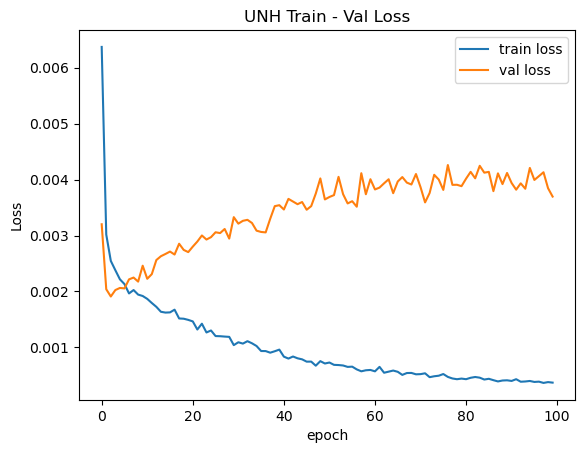

In [500]:
val_train_loss_plot(history)

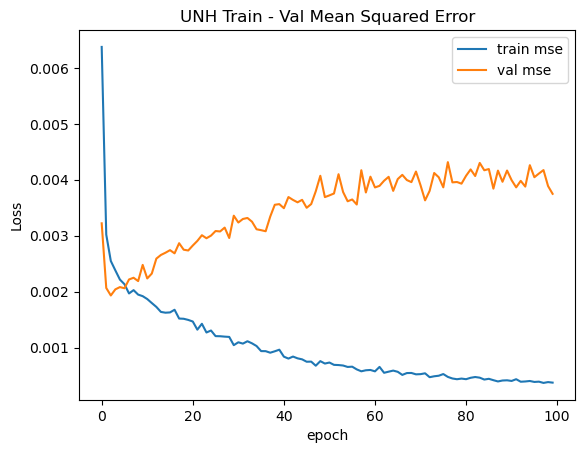

In [501]:
val_train_mse_plot(history)

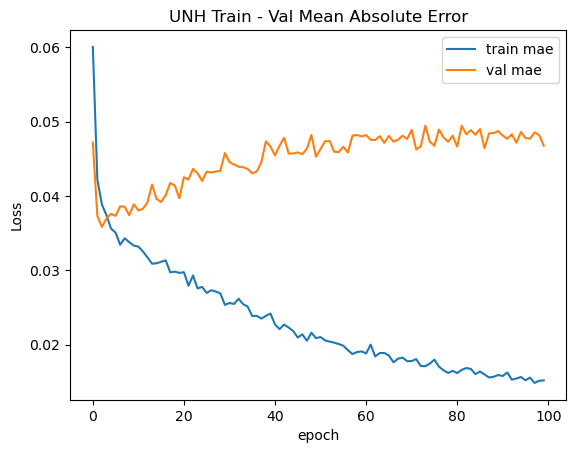

In [502]:
val_train_mae(history)

In [503]:
# After the model has been constructed, we'll summarise it
from tensorflow.keras.utils import plot_model
print(cnn_lstm_model.summary())
plot_model(cnn_lstm_model, to_file='CNN_LSTM.png', show_shapes=True, show_layer_names=True)

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_63                  │ (None, 1, 98, 64)           │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_64                  │ (None, 1, 49, 64)           │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_65                  │ (None, 1, 47, 128)          │          24,704 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_66                  │ (None, 1, 23, 128)          │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_67                  │ (None, 1, 21, 64)           │          24,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_68                  │ (None, 1, 10, 64)           │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_69                  │ (None, 1, 640)              │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_18 (Bidirectional)     │ (None, 1, 200)              │         592,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_66 (Dropout)                 │ (None, 1, 200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_19 (Bidirectional)     │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_67 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,650,205 (10.11 MB)

 Trainable params: 883,401 (3.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,766,804 (6.74 MB)

None
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [504]:
cnn_lstm_model.evaluate(test_X, test_Y)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 - mae: 0.0568 - mse: 0.0059


[0.0036952265072613955, 0.046768516302108765, 0.0037483079358935356]

In [505]:
yhat_probs = cnn_lstm_model.predict(test_X, verbose=0)
yhat_probs = yhat_probs[:, 0]

var = explained_variance_score(test_Y.reshape(-1,1), yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(test_Y.reshape(-1,1), yhat_probs)
print('R2 Score: %f' % var)

var2 = max_error(test_Y.reshape(-1,1), yhat_probs)
print('Max Error: %f' % var2)

Variance: 0.586816
R2 Score: 0.586816
Max Error: 0.296007


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


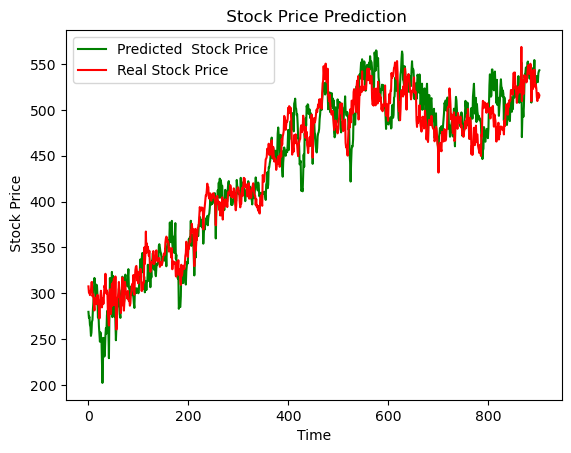

In [506]:
predicted  = cnn_lstm_model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = stock.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [507]:
avg_mse = sum(history.history["mse"]) / len(history.history["mse"])
min_mse = min(history.history["mse"])
max_mse = max(history.history["mse"])
avg_mse, min_mse, max_mse 

(0.0009855187076027506, 0.00036712735891342163, 0.00637478893622756)

In [508]:
cnn_lstm_df = create_pred_real_df(test_label, predicted)
cnn_lstm_df

,Real,Predicted,Volatility
0,307.442694,279.673187,0.000000
1,300.651739,273.062134,0.000000
2,301.497760,274.381287,0.431843
3,297.946715,265.468048,0.484651
4,302.648729,263.160461,0.434534
...,...,...,...
899,509.607927,530.641174,0.981442
900,514.833965,530.240601,0.980898
901,518.377886,539.760498,0.980503
902,513.063379,542.180298,0.979966


# RNN <a class="anchor" id="rnn"></a>

## Data Preparation <a class="anchor" id="data_prep_rnn"></a>

In [509]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(stock.drop("Date", axis=1))
window_size = 100

X = []
y = []
for i in range(window_size, len(stock)):
    X.append(training_set_scaled[i-window_size:i, 0])
    y.append(training_set_scaled[i, 0])
    
X_train = X[:train_test_split_index]
X_test = X[train_test_split_index:]
y_train = y[:train_test_split_index]
y_test = y[train_test_split_index:]

X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(len(X_train))
print(len(X_test))

2316
906


## Model <a class="anchor" id="model_rnn"></a>

In [510]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

rnn_model = Sequential()

rnn_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
rnn_model.add(Dropout(0.2))
rnn_model.add(LSTM(units = 50, return_sequences = True))
rnn_model.add(Dropout(0.2))
rnn_model.add(LSTM(units = 50, return_sequences = True))
rnn_model.add(Dropout(0.2))
rnn_model.add(LSTM(units = 50))
rnn_model.add(Dropout(0.2))

rnn_model.add(Dense(units = 1))

rnn_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse', 'mae'])
history = rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 25, batch_size = 32, shuffle=False)

Epoch 1/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - loss: 5.2422e-04 - mae: 0.0177 - mse: 5.2408e-04 - val_loss: 0.0770 - val_mae: 0.2486 - val_mse: 0.0757
Epoch 2/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 173ms/step - loss: 0.0176 - mae: 0.0936 - mse: 0.0176 - val_loss: 0.1072 - val_mae: 0.2852 - val_mse: 0.1051
Epoch 3/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 158ms/step - loss: 0.0340 - mae: 0.1173 - mse: 0.0340 - val_loss: 0.2194 - val_mae: 0.4266 - val_mse: 0.2154
Epoch 4/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - loss: 0.0319 - mae: 0.1175 - mse: 0.0319 - val_loss: 0.1583 - val_mae: 0.3573 - val_mse: 0.1553
Epoch 5/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - loss: 0.0458 - mae: 0.1583 - mse: 0.0458 - val_loss: 0.0770 - val_mae: 0.2408 - val_mse: 0.0755
Epoch 6/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 14s 198ms/step - loss: 0.0471 - mae: 0.1758 - mse: 0.0471 - val_loss: 0.2650 - val_mae: 0.4907 - val_mse: 0.2617
Epoch 7/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - loss: 0.0322 - mae: 0.1542 - ms

## Evaluation <a class="anchor" id="eval_rnn"></a>

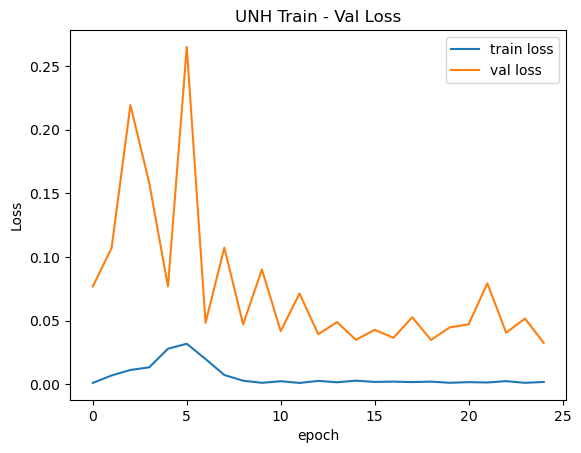

In [511]:
val_train_loss_plot(history)

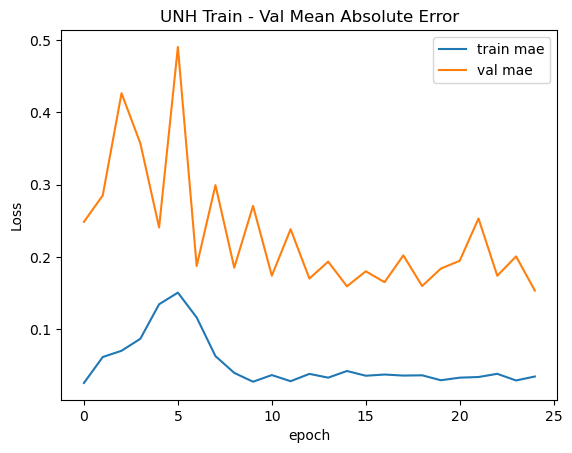

In [512]:
val_train_mae(history)

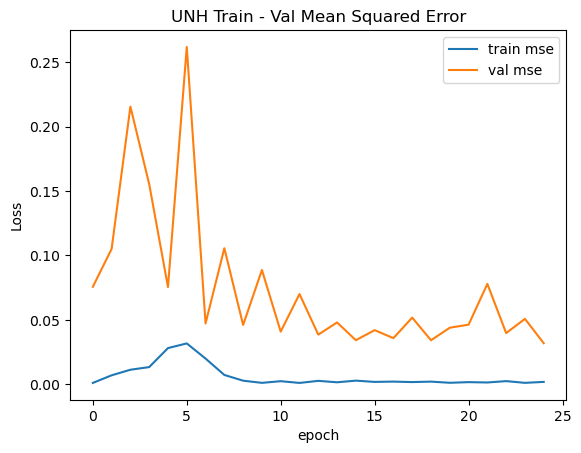

In [513]:
val_train_mse_plot(history)

In [514]:
print(rnn_model.summary())
plot_model(rnn_model, to_file='RNN.png', show_shapes=True, show_layer_names=True)

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_68 (LSTM)                       │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_68 (Dropout)                 │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_69 (LSTM)                       │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_69 (Dropout)                 │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_70 (LSTM)                       │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_70 (Dropout)                 │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_71 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_71 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 213,155 (832.64 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 142,104 (555.10 KB)

None
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [515]:
rnn_model.evaluate(X_test, y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0148 - mae: 0.0862 - mse: 0.0148


[0.03262900188565254, 0.15343289077281952, 0.03197847679257393]

In [516]:
yhat_probs = rnn_model.predict(X_test, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

var = explained_variance_score(y_test.reshape(-1,1), yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(y_test.reshape(-1,1), yhat_probs)
print('R2 Score: %f' % var)

var2 = max_error(y_test.reshape(-1,1), yhat_probs)
print('Max Error: %f' % var2)

Variance: 0.609431
R2 Score: 0.609431
Max Error: 0.311791


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


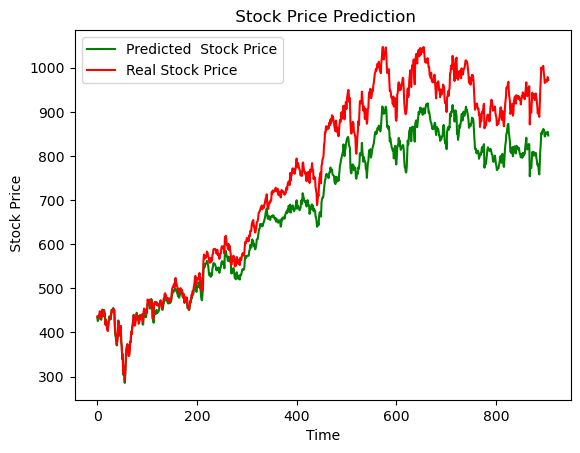

In [517]:
predicted  = rnn_model.predict(X_test)
test_label = y_test.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(X_train)
for j in range(len_t , len_t + len(X_test)):
    temp = stock.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [518]:
avg_mse = sum(history.history["mse"]) / len(history.history["mse"])
min_mse = min(history.history["mse"])
max_mse = max(history.history["mse"])
avg_mse, min_mse, max_mse 

(0.006189334308728576, 0.0011936163064092398, 0.031824126839637756)

In [519]:
rnn_df = create_pred_real_df(test_label, predicted)
rnn_df

,Real,Predicted,Volatility
0,436.146750,433.700348,0.000000
1,432.635247,425.689819,0.000000
2,436.307719,430.179749,0.438238
3,436.467734,431.036224,0.368009
4,441.070807,435.145142,0.352387
...,...,...,...
901,972.035579,853.120728,0.531075
902,968.267211,849.438538,0.530805
903,969.513936,850.224365,0.530511
904,978.724808,854.697266,0.530237


# XGBoost <a class="anchor" id="xgboost"></a>

## Data Preparation <a class="anchor" id="data_prep_xgboost"></a>

In [520]:
stock["Pct_change"] = stock["Adj Close"].pct_change()

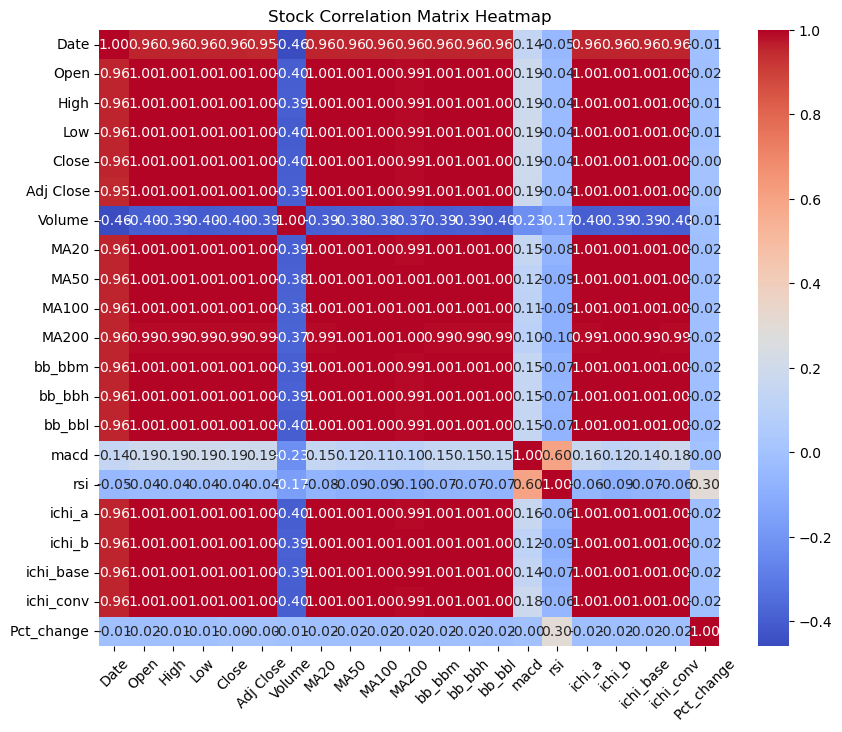

In [521]:
create_corr_matrix(stock)

In [522]:
# Dataframe with Adj close, ts_polarity, twitter_volume of APPL
stock = stock[["Adj Close", "rsi", "Volume", "MA200", "Pct_change"]]
stock.dropna(inplace = True)
stock

,Adj Close,rsi,Volume,MA200,Pct_change
201,29.964525,0.000000,10386500,32.15430,0.040510
202,29.768719,0.000000,6840200,32.17780,-0.006535
203,30.396898,0.000000,6622900,32.19905,0.021102
204,30.641640,0.000000,7456100,32.22335,0.008052
205,30.649794,0.000000,8050600,32.24660,0.000266
...,...,...,...,...,...
3517,518.266907,36.690509,1759500,501.82720,0.000827
3518,517.988037,36.501070,1390800,502.12570,-0.000538
3519,520.737183,39.800836,1851800,502.42125,0.005307
3520,522.838928,42.270786,2001000,502.72285,0.004036


In [523]:
def window_data(df, window, feature_col_number1, feature_col_number2, feature_col_number3, feature_col_number4, feature_col_number5, target_col_number):
    # Create empty lists "X_adj_close", "rsi", "X_volume" and y
    X_adj_close = []
    X_rsi = []
    X_ma200 = []
    X_volume = []
    X_pct_change = []
    y = []
    for i in range(len(df) - window):
        adj_close = df.iloc[i:(i + window), feature_col_number1]
        rsi = df.iloc[i:(i + window), feature_col_number2]
        volume = df.iloc[i:(i + window), feature_col_number3]
        ma_200 = df.iloc[i:(i + window), feature_col_number4]
        pct_change = df.iloc[i:(i + window), feature_col_number5]
        target = df.iloc[(i + window), target_col_number]

        # Append values in the lists
        X_adj_close.append(adj_close)
        X_rsi.append(rsi)
        X_volume.append(volume)
        X_ma200.append(ma_200)
        X_pct_change.append(pct_change)
        y.append(target)

    return np.hstack((X_adj_close, X_rsi, X_volume, X_ma200, X_pct_change)), np.array(y).reshape(-1, 1)

In [524]:
window_size = 3
X, y = window_data(stock, window_size, 0, 1, 2, 3, 4, 0)
X, y

(array([[ 2.99645252e+01,  2.97687187e+01,  3.03968983e+01, ...,
          4.05100433e-02, -6.53461057e-03,  2.11020016e-02],
        [ 2.97687187e+01,  3.03968983e+01,  3.06416397e+01, ...,
         -6.53461057e-03,  2.11020016e-02,  8.05152676e-03],
        [ 3.03968983e+01,  3.06416397e+01,  3.06497936e+01, ...,
          2.11020016e-02,  8.05152676e-03,  2.66105714e-04],
        ...,
        [ 5.17838623e+02,  5.18266907e+02,  5.17988037e+02, ...,
          7.65611555e-03,  8.27060154e-04, -5.38081103e-04],
        [ 5.18266907e+02,  5.17988037e+02,  5.20737183e+02, ...,
          8.27060154e-04, -5.38081103e-04,  5.30735328e-03],
        [ 5.17988037e+02,  5.20737183e+02,  5.22838928e+02, ...,
         -5.38081103e-04,  5.30735328e-03,  4.03609666e-03]]),
 array([[ 30.64163971],
        [ 30.64979362],
        [ 29.3118782 ],
        ...,
        [520.73718262],
        [522.83892822],
        [524.40270996]]))

In [525]:
X_train = X[: train_test_split_index]
X_test = X[train_test_split_index:]
y_train = y[: train_test_split_index]
y_test = y[train_test_split_index:]

In [526]:
from sklearn.preprocessing import MinMaxScaler

# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

print(len(X_train))
print(len(X_test))

2316
1002


## Model <a class="anchor" id="model_xgboost"></a>

In [527]:
parameters = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12],
    'gamma': [0.001, 0.01],
    'random_state': [42]
}

model = XGBRegressor(objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters, cv=5, verbose=False)

In [528]:
clf.fit(X_train, y_train.ravel())

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.001, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200, 'random_state': 42}
Best validation score = -0.9052636019053203


In [529]:
model_xgboost = XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model_xgboost.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.001, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## Evaluation <a class="anchor" id="eval_xgboost"></a>

In [530]:
predicted = model_xgboost.predict(X_test)
predicted

array([0.22267218, 0.22543858, 0.22502877, ..., 0.91625386, 0.9168039 ,
       0.92430097], dtype=float32)

In [531]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

Root Mean Squared Error: 0.02973920134414908
R-squared : 0.9862043966316428


In [532]:
predicted_prices = y_test_scaler.inverse_transform(predicted.reshape(-1, 1))
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [533]:
predicted

array([0.22267218, 0.22543858, 0.22502877, ..., 0.91625386, 0.9168039 ,
       0.92430097], dtype=float32)

In [534]:
y_test_scaler.inverse_transform(predicted.reshape(-1,1))

array([[265.22726],
       [266.23694],
       [266.08734],
       ...,
       [518.3615 ],
       [518.56226],
       [521.2984 ]], dtype=float32)

In [535]:
xgboost_df = create_pred_real_df(real_prices, predicted_prices)
xgboost_df

,Real,Predicted,Volatility
0,278.142334,265.227264,0.000000
1,276.563110,266.236938,0.000000
2,277.418549,266.087341,0.068998
3,268.695374,271.247437,0.268300
4,270.941986,269.497223,0.300896
...,...,...,...
997,518.266907,518.361511,0.512752
998,517.988037,518.361511,0.512496
999,520.737183,518.361511,0.512240
1000,522.838928,518.562256,0.511984


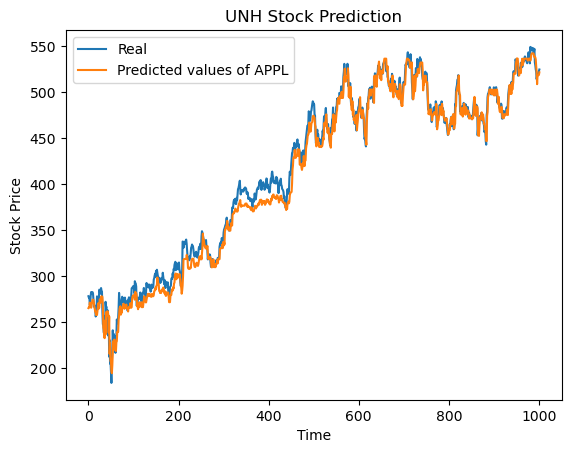

In [536]:
plt.plot(real_prices, label = 'Real')
plt.plot(predicted_prices, label = 'Predicted values of APPL')
plt.title(f'{STOCK_NAME} Stock Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Save Datasets <a class="anchor" id="save_datasets"></a>

In [537]:
if STOCK_NAME == "AAPL":
    xgboost_df.to_csv(STOCK_NAME + df_postfix, index=False)
if STOCK_NAME == "TSLA":
    rnn_df.to_csv(STOCK_NAME + DF_POSTFIX, index=False)
if STOCK_NAME == "META":
    xgboost_df.to_csv(STOCK_NAME + DF_POSTFIX, index=False)
if STOCK_NAME == "NVDA":
    save_xgboost_df()
if STOCK_NAME == "GOOGL":
    save_xgboost_df()
if STOCK_NAME == "AMZN":
    save_cnn_lstm_df()
if STOCK_NAME == "MSFT":
    save_xgboost_df()
if STOCK_NAME == "INTC":
    save_rnn_df()
if STOCK_NAME == "BRK-B":
    save_xgboost_df()
if STOCK_NAME == "UNH":
    save_xgboost_df()